In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [ ]:
# MNIST Image --> Tensors

In [ ]:
transform = transforms.ToTensor()
transform

ToTensor()

In [ ]:
train_data = datasets.MNIST(root = "drive/MyDrive/PyTorch/Data",train=True, download = True, transform = transform)

In [ ]:
test_data = datasets.MNIST(root = "drive/MyDrive/PyTorch/Data",train = False, download = True, transform = transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: drive/MyDrive/PyTorch/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: drive/MyDrive/PyTorch/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
type(test_data),type(train_data)

(torchvision.datasets.mnist.MNIST, torchvision.datasets.mnist.MNIST)

In [ ]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

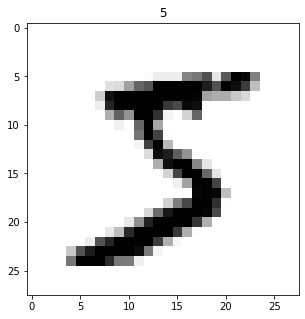

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(image.reshape(28,28), cmap = "gist_yarg")
plt.title(label)
plt.show()

In [ ]:
torch.manual_seed(101)

# 0 images, 1 images 
train_loader = DataLoader(train_data, batch_size = 100, shuffle = True)

test_loader = DataLoader(test_data, batch_size = 500, shuffle = False)

In [ ]:
from torchvision.utils import make_grid

In [ ]:
np.set_printoptions(formatter = dict(int=lambda x : f"{x:4}")) # Formating

In [ ]:
for images, labels in train_loader:
    break

In [ ]:
images.shape,labels.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [ ]:
im = make_grid(images[:12], nrow = 12)

im.numpy().shape, np.transpose(im.numpy()).shape

((3, 32, 362), (362, 32, 3))

Labels :  [   7    2    3    5    8    5    3    6    9    9    1    3]


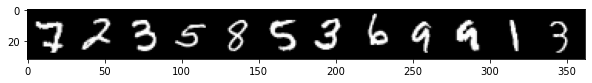

In [ ]:
print("Labels : ", labels[:12].numpy())

plt.figure(figsize = (10,4))
# from CWH to WHC 
plt.imshow(np.transpose(im.numpy(), (1,2,0)))
plt.show()

In [ ]:
# nn.ReLU
# F.relu

In [ ]:
class MultilayerPerceptron(nn.Module):

    def __init__(self, in_sz = 784, out_sz = 10, layers = [120,83]):

        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self, X):

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim = 1) # Multi Class Classification

In [ ]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=83, bias=True)
  (fc3): Linear(in_features=83, out_features=10, bias=True)
)

In [ ]:
# ANN -- > CNN
for param in model.parameters():
    print(param.numel())

94080
120
9960
83
830
10


In [ ]:
# 105, 214 total parameters

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
images.shape,labels.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [ ]:
images.view(100,-1).shape

torch.Size([100, 784])

In [ ]:
import time

start_time = time.time()

# Training
epochs = 10

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []


for i in range(epochs):

    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):

        b+=1

        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)

        # Burda üretmiş olduğun y_pred --> y_pred.data.shape[100,10] 
        # Biz burdan max uygulamamız lazım ki hangisi seçiyor [1] olarak yazmamız orada argmax değeri oluyor !!!
        # Predicted --> predicted.shape -- > [100] olarak dönüyor 
        # Zaten bizim her y_train -- > shape olarak [100] olduğu için
        # Aralarından kaç tanesi doğru ise onu dönüyor...

        ##print(y_pred.data.shape)
        predicted = torch.max(y_pred.data,1)[1]

        ##print(predicted.shape)
        batch_corr = (predicted == y_train).sum()
        trn_corr+=batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 200 == 0:
            acc = trn_corr.item() * 100 / (100*b)
            print(f"Epoch : {i:4} , Batch : {b:4}, Loss : {loss.item():4.3f}, Accuracy : {acc:.3f}")

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():

        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test.view(500,-1))

            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


total_time = time.time() - start_time

print()
print(f"Duration : {total_time / 60} Minutes")


# 600 de sonlanması zaten her bir batch 100 tane olduğu için toplam yine 60000 elden geçirmiş oluyor!!

Epoch :    0 , Batch :  200, Loss : 0.218, Accuracy : 82.765
Epoch :    0 , Batch :  400, Loss : 0.261, Accuracy : 87.097
Epoch :    0 , Batch :  600, Loss : 0.207, Accuracy : 89.163
Epoch :    1 , Batch :  200, Loss : 0.112, Accuracy : 94.420
Epoch :    1 , Batch :  400, Loss : 0.124, Accuracy : 94.705
Epoch :    1 , Batch :  600, Loss : 0.104, Accuracy : 94.940
Epoch :    2 , Batch :  200, Loss : 0.155, Accuracy : 96.415
Epoch :    2 , Batch :  400, Loss : 0.057, Accuracy : 96.457
Epoch :    2 , Batch :  600, Loss : 0.185, Accuracy : 96.538
Epoch :    3 , Batch :  200, Loss : 0.052, Accuracy : 97.485
Epoch :    3 , Batch :  400, Loss : 0.049, Accuracy : 97.380
Epoch :    3 , Batch :  600, Loss : 0.061, Accuracy : 97.338
Epoch :    4 , Batch :  200, Loss : 0.099, Accuracy : 97.895
Epoch :    4 , Batch :  400, Loss : 0.059, Accuracy : 97.880
Epoch :    4 , Batch :  600, Loss : 0.056, Accuracy : 97.862
Epoch :    5 , Batch :  200, Loss : 0.074, Accuracy : 98.400
Epoch :    5 , Batch :  

In [ ]:
len(train_loader),len(test_loader)

(600, 20)

In [ ]:
np.array(train_losses).shape,np.array(test_losses).shape

((10,), (10,))

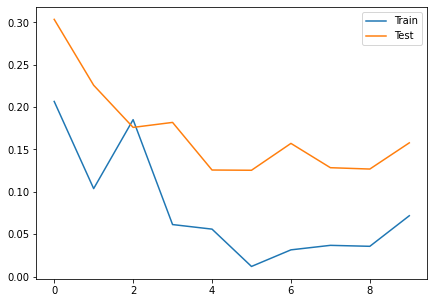

In [ ]:
plt.figure(figsize = (7,5))

plt.plot(train_losses, label = "Train")
plt.plot(test_losses, label = "Test")

plt.legend(loc = "best")
plt.show()

In [ ]:
train_acc = [t/600 for t in train_correct]
train_acc

[tensor(89.1633),
 tensor(94.9400),
 tensor(96.5383),
 tensor(97.3383),
 tensor(97.8617),
 tensor(98.3667),
 tensor(98.6300),
 tensor(98.8133),
 tensor(99.0700),
 tensor(99.1950)]

In [ ]:
test_acc = [t/100 for t in test_correct]
test_acc

[tensor(94.0600),
 tensor(95.8200),
 tensor(96.6900),
 tensor(96.8500),
 tensor(97.2300),
 tensor(97.4400),
 tensor(96.4900),
 tensor(97.5700),
 tensor(97.5700),
 tensor(97.4500)]

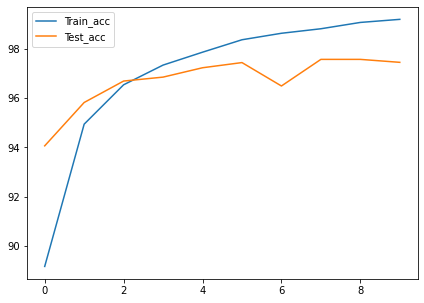

In [ ]:
plt.figure(figsize = (7,5))

plt.plot(train_acc, label = "Train_acc")
plt.plot(test_acc, label = "Test_acc")

plt.legend(loc = "best")
plt.show()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: drive/MyDrive/PyTorch/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
# New UnSeen Data

test_load_all = DataLoader(test_data , batch_size = 10000 , shuffle = True)

In [ ]:
with torch.no_grad():
    correct = 0

    for X_test,y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct +=(predicted == y_test).sum()

In [ ]:
correct.item() / len(test_data)*100

97.45

In [ ]:
predicted.shape

torch.Size([10000])

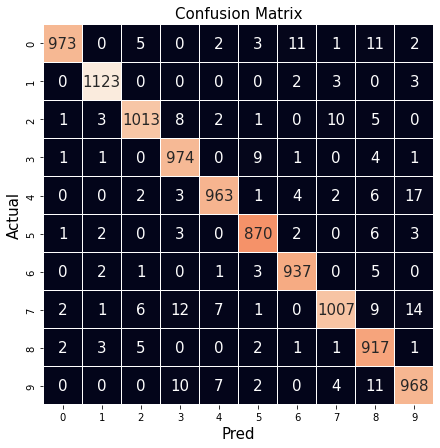

In [ ]:
import seaborn as sns

cm = confusion_matrix(predicted.view(-1), y_test.view(-1))
size = 15
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True, linewidths=.3, linecolor="white", fmt = "d" , cbar = False , annot_kws = {"size" : 15})
plt.ylabel("Actual", fontsize = 15)
plt.xlabel("Pred", fontsize = 15)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

# MNIST With CNN

In [ ]:
transforms = transforms.ToTensor()

In [ ]:
path = "drive/MyDrive/PyTorch/Data"

train_data = datasets.MNIST(root = path , download = True, train = True, transform = transforms)

test_data = datasets.MNIST(root = path, download = True , train = False, transform = transforms)

In [ ]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [ ]:
# 1 Color Channel , 6 Filters , 3by3 Kernel, Stride 1 ;
conv1 = nn.Conv2d(1,6,3,1)

# 6 Input Filters, 16 Filters, 3by3 kernel , Stride 1;
conv2 = nn.Conv2d(6,16,3,1)

In [ ]:
for i, (X_train,y_train) in enumerate(train_data):
    break

In [ ]:
X_train.shape, y_train

(torch.Size([1, 28, 28]), 5)

In [ ]:
x = X_train.view(1,1,28,28) # 4D --- > 4D Batch (batch of 1 image)
x.shape

torch.Size([1, 1, 28, 28])

In [ ]:
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 26, 26])

In [ ]:
# kernel , strides
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 6, 13, 13])

In [ ]:
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [ ]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

In [ ]:
11 / 2, (((28-2) / 2) -2) / 2

(5.5, 5.5)

In [ ]:
x.shape

torch.Size([1, 16, 5, 5])

In [ ]:
# Flatten !!
x = x.view(-1,16*5*5)
x.shape

torch.Size([1, 400])

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)     

    def forward(self, X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim = 1)

In [ ]:
torch.manual_seed(42)

model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
len(train_loader)

6000

In [ ]:
import time

start_time = time.time()

# Variables (Trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop Epochs
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0

    # TRAIN
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr +=batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b %600 == 0 :
            print(f"EPOCH : {i:4} , Batch : {b:4.4f} , Loss : {loss.item():.4f}")
            
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # TEST


    with torch.no_grad():

        for b, (X_test,y_test) in enumerate(test_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val , y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print()
print(f"Training took {total / 60} minutes ")

EPOCH :    0 , Batch : 600.0000 , Loss : 0.0406
EPOCH :    0 , Batch : 1200.0000 , Loss : 0.0825
EPOCH :    0 , Batch : 1800.0000 , Loss : 0.3642
EPOCH :    0 , Batch : 2400.0000 , Loss : 0.0186
EPOCH :    0 , Batch : 3000.0000 , Loss : 0.0084
EPOCH :    0 , Batch : 3600.0000 , Loss : 0.0024
EPOCH :    0 , Batch : 4200.0000 , Loss : 0.5999
EPOCH :    0 , Batch : 4800.0000 , Loss : 0.0220
EPOCH :    0 , Batch : 5400.0000 , Loss : 0.0071
EPOCH :    0 , Batch : 6000.0000 , Loss : 0.0580
EPOCH :    1 , Batch : 600.0000 , Loss : 0.0130
EPOCH :    1 , Batch : 1200.0000 , Loss : 0.0478
EPOCH :    1 , Batch : 1800.0000 , Loss : 0.0014
EPOCH :    1 , Batch : 2400.0000 , Loss : 0.0227
EPOCH :    1 , Batch : 3000.0000 , Loss : 0.4363
EPOCH :    1 , Batch : 3600.0000 , Loss : 0.0010
EPOCH :    1 , Batch : 4200.0000 , Loss : 0.0007
EPOCH :    1 , Batch : 4800.0000 , Loss : 0.0006
EPOCH :    1 , Batch : 5400.0000 , Loss : 0.0004
EPOCH :    1 , Batch : 6000.0000 , Loss : 0.0154
EPOCH :    2 , Batch :

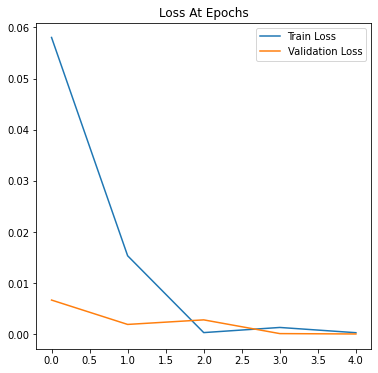

In [ ]:
plt.figure(figsize = (6,6))
plt.plot(train_losses , label = "Train Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.title("Loss At Epochs")
plt.legend(loc = "best")
plt.show()

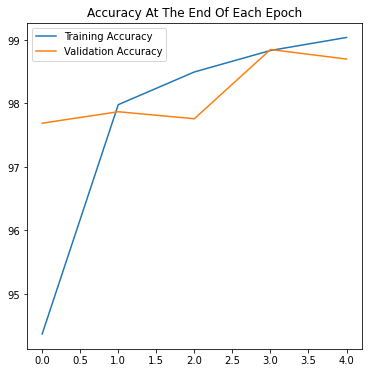

In [ ]:
plt.figure(figsize = (6,6))
plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy At The End Of Each Epoch")
plt.legend(loc = "best")
plt.show()

In [ ]:
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct +=(predicted == y_test).sum()

acc = correct.item() / len(test_data)
print("Accuracy : ", acc)

Accuracy :  0.987


In [ ]:
predicted.shape, y_test.shape

(torch.Size([10000]), torch.Size([10000]))

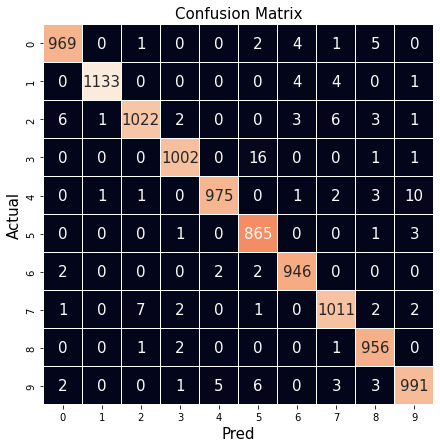

In [ ]:
import seaborn as sns

cm = confusion_matrix(predicted.view(-1), y_test.view(-1))
size = 15
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True, linewidths=.3, linecolor="white", fmt = "d" , cbar = False , annot_kws = {"size" : 15})
plt.ylabel("Actual", fontsize = 15)
plt.xlabel("Pred", fontsize = 15)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

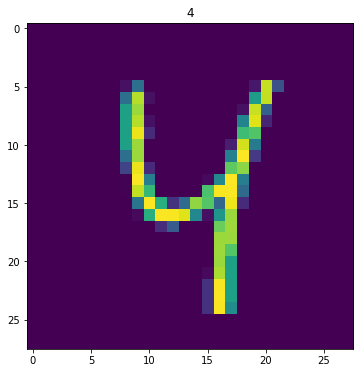

In [ ]:
plt.figure(figsize = (6,6))
plt.imshow((test_data[2022])[0].reshape(28,28))
plt.title(test_data[2022][1])
plt.show()

In [ ]:
model.eval()
with torch.no_grad():

    new_pred = model(test_data[2022][0].view(1,1,28,28))
    new_pred = torch.max(new_pred , 1)[1].item()

print("Prediction : ", new_pred)
print("Actual : ", test_data[2022][1])

Prediction :  4
Actual :  4


---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
transform = transforms.ToTensor()

In [ ]:
path = "drive/MyDrive/PyTorch/Data"
train_data = datasets.CIFAR10(root = path , train = True, download = True, transform=transform)
test_data = datasets.CIFAR10(root = path , train = False, download = True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting drive/MyDrive/PyTorch/Data/cifar-10-python.tar.gz to drive/MyDrive/PyTorch/Data
Files already downloaded and verified


In [ ]:
train_data,test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: drive/MyDrive/PyTorch/Data
     Split: Train
     StandardTransform
 Transform: ToTensor(), Dataset CIFAR10
     Number of datapoints: 10000
     Root location: drive/MyDrive/PyTorch/Data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [ ]:
len(train_loader),len(test_loader)

(5000, 1000)

In [ ]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [ ]:
for images, labels in train_loader:
    break

In [ ]:
labels 

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

In [ ]:
images.shape , np.transpose(im.numpy(), (1,2,0)).shape

(torch.Size([10, 3, 32, 32]), (70, 172, 3))

In [ ]:
32*5

160

In [ ]:
np.array([class_names[i] for i in labels])

array(['  car', '  dog', ' ship', '  car', ' frog', '  car', ' frog',
       '  cat', 'horse', 'truck'], dtype='<U5')

Label :  [   1    5    8    1    6    1    6    3    7    9]
Class :    car   dog  ship   car  frog   car  frog   cat horse truck


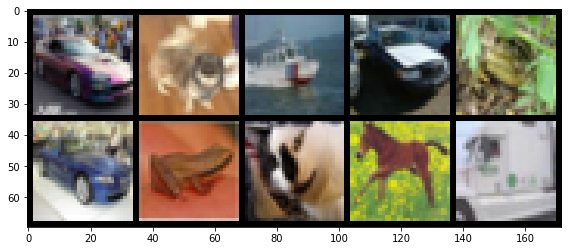

In [ ]:
print("Label : ", labels.numpy())
print("Class : ", *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow = 5)

plt.figure(figsize = (10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))
plt.show()

In [ ]:
images[0].shape, (((32-2)/2) -2 )/ 2

(torch.Size([3, 32, 32]), 6.5)

In [ ]:
from tensorflow.keras.models import Sequential

from  tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten


In [ ]:
from tensorflow.keras.models import Sequential

from  tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten


# Tensorflow ile kontrol !! :D
# 3,3 kernel da -2 --> 5,5 da -4
model = Sequential()

model.add(Conv2D(filters=6, kernel_size = (5,5), activation="relu", strides = 1,input_shape = (32,32,1)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=16, kernel_size = (3,3),strides = 1, activation="relu", ))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(units = 120 , activation = "relu"))
model.add(Dense(units = 84 , activation = "relu"))
model.add(Dense(units = 10, activation = "log_softmax" ))

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 12, 12, 16)        880       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 6, 6, 16)         0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 576)               0         
                                                                 
 dense_9 (Dense)             (None, 120)             

In [ ]:
class CNN(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.softmax(X ,dim = 1)

In [ ]:
torch.manual_seed(101)
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
import time

start_time = time.time()

# Variables (Trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop Epochs
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0

    # TRAIN
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr +=batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b %600 == 0 :
            print(f"EPOCH : {i:4} , Batch : {b:4.4f} , Loss : {loss.item():.4f}")
            
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # TEST


    with torch.no_grad():

        for b, (X_test,y_test) in enumerate(test_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val , y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print()
print(f"Training took {total / 60} minutes ")

EPOCH :    0 , Batch : 600.0000 , Loss : 2.2498
EPOCH :    0 , Batch : 1200.0000 , Loss : 2.2481
EPOCH :    0 , Batch : 1800.0000 , Loss : 1.8571
EPOCH :    0 , Batch : 2400.0000 , Loss : 2.0228
EPOCH :    0 , Batch : 3000.0000 , Loss : 1.9354
EPOCH :    0 , Batch : 3600.0000 , Loss : 2.3651
EPOCH :    0 , Batch : 4200.0000 , Loss : 2.0981
EPOCH :    0 , Batch : 4800.0000 , Loss : 1.9597
EPOCH :    1 , Batch : 600.0000 , Loss : 2.2044
EPOCH :    1 , Batch : 1200.0000 , Loss : 2.1184
EPOCH :    1 , Batch : 1800.0000 , Loss : 2.1829
EPOCH :    1 , Batch : 2400.0000 , Loss : 1.8013
EPOCH :    1 , Batch : 3000.0000 , Loss : 1.9788
EPOCH :    1 , Batch : 3600.0000 , Loss : 2.1849
EPOCH :    1 , Batch : 4200.0000 , Loss : 2.0290
EPOCH :    1 , Batch : 4800.0000 , Loss : 1.9439
EPOCH :    2 , Batch : 600.0000 , Loss : 2.2591
EPOCH :    2 , Batch : 1200.0000 , Loss : 2.0879
EPOCH :    2 , Batch : 1800.0000 , Loss : 1.9704
EPOCH :    2 , Batch : 2400.0000 , Loss : 1.9053
EPOCH :    2 , Batch : 

In [ ]:
torch.save(model.state_dict(), "myCIFARmodel.pt")

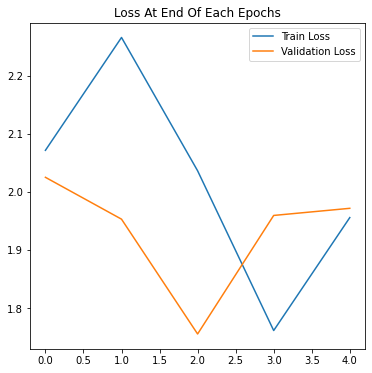

In [ ]:
plt.figure(figsize = (6,6))
plt.plot(train_losses , label = "Train Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.title("Loss At End Of Each Epochs")
plt.legend(loc = "best")
plt.show()

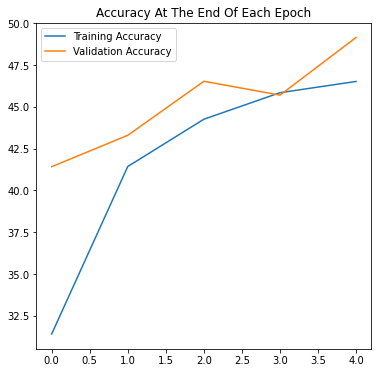

In [ ]:
plt.figure(figsize = (6,6))
plt.plot([t/500 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy At The End Of Each Epoch")
plt.legend(loc = "best")
plt.show()

In [ ]:
print(test_correct)

[tensor(4142), tensor(4330), tensor(4653), tensor(4570), tensor(4915)]


In [ ]:
num_c = test_correct[-1].item()
num_c*100 / 10000

49.15

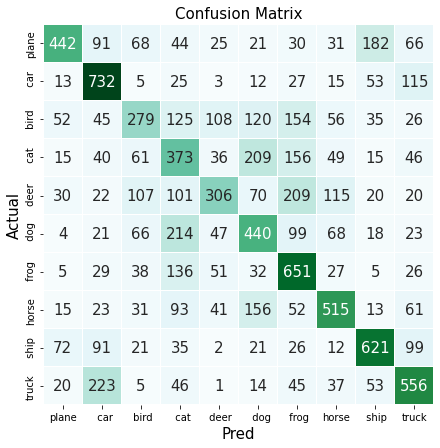

In [ ]:
import seaborn as sns

test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:

        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct +=(predicted == y_test).sum()

cm = confusion_matrix(y_test.view(-1), predicted.view(-1))
size = 15
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True, linewidths=.3, linecolor="white", fmt = "d" , cbar = False , cmap = "BuGn",annot_kws = {"size" : 15},
            xticklabels=class_names,yticklabels = class_names)
plt.ylabel("Actual", fontsize = 15)
plt.xlabel("Pred", fontsize = 15)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()